In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.


#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# 고정적 seed 42로 고정.
import os
import random
import numpy as np
import tensorflow as tf
import logging


SEED =42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def set_global_determinism(seed=SEED, fast_n_close=False):
    """
        Enable 100% reproducibility on operations related to tensor and randomness.
        Parameters:
        seed (int): seed value for global randomness
        fast_n_close (bool): whether to achieve efficient at the cost of determinism/reproducibility
    """
    set_seeds(seed=seed)
    if fast_n_close:
        return

    logging.warning("*******************************************************************************")
    logging.warning("*** set_global_determinism is called,setting full determinism, will be slow ***")
    logging.warning("*******************************************************************************")

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    # https://www.tensorflow.org/api_docs/python/tf/config/threading/set_inter_op_parallelism_threads
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
#     from tfdeterminism import patch
#     patch()    
    
set_seeds(42)
set_global_determinism(42)

In [3]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM, BatchNormalization
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
import kerastuner as kt
import IPython

from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
import IPython


import matplotlib.pyplot as plt

In [4]:
#우선 교차검증 시 데이터 분할이 어떻게 이루어지는지 그려 볼 수 있게 해주는 helper function을 가져오자.
from sklearn.model_selection import TimeSeriesSplit 
from matplotlib.patches import Patch
import matplotlib.pyplot as plt 

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')


def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

# 데이터 설명
* TurbID - 발전기 ID
* Day - 날짜
* Tmstamp - 시간
* Wspd - 풍속
* Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이
* Etmp - 외부 온도
* Itmp - 터빈 내부 온도
* Ndir - 터빈이 바라보는 방향 각도
* Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름
* Prtv - 무효전력 : 에너지원을 필요로  하지 않는 전력
* Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력 <br><br>

* <b>label: Patv </b>
# 결론적으로 134개 터빈의 201~202일, 즉 2일간의 Patv값을 예측해야 합니다.


# EDA
<font color=red>
1. Tmstamp를 hour, minute으로 변환 <br>
2. group1~6 column 생성 <br>
3. hour, Day, TurbID, minute순으로 재정렬 후 interpolate해서 결측치 처리 <br>

</font>

In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [11]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [7]:
train_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23:10,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,23:20,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,23:30,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,23:40,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [8]:
train_data[100:120]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
100,1,1,16:40,5.34,-8.48,38.25,46.45,47.41,0.99,0.99,0.99,-0.22,326.50
101,1,1,16:50,2.19,0.45,38.09,46.28,9.03,0.99,0.99,0.99,-0.19,55.45
102,1,1,17:00,4.03,30.12,38.46,47.31,52.05,1.73,1.73,1.73,0.14,1.78
103,1,1,17:10,4.24,-9.59,38.50,47.67,61.25,0.99,0.99,0.99,-0.20,182.95
104,1,1,17:20,3.18,5.89,38.07,46.61,45.30,0.99,0.99,0.99,-0.23,118.31
105,1,1,17:30,4.13,-2.18,37.88,46.33,81.45,0.99,0.99,0.99,-0.21,171.35
106,1,1,17:40,3.82,4.76,37.55,46.05,69.99,0.99,0.99,0.99,-0.24,203.60
107,1,1,17:50,3.30,-4.46,37.31,45.79,69.10,0.99,0.99,0.99,-0.19,135.88
108,1,1,18:00,2.67,2.24,37.36,45.77,82.54,1.01,1.01,1.01,-0.05,69.04
109,1,1,18:10,4.48,-1.19,37.41,45.68,80.04,0.99,0.99,0.99,-0.25,237.39


In [9]:
df_updated = train_data.copy()

In [10]:
df_updated

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23:10,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,23:20,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,23:30,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,23:40,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [11]:
df = df_updated[['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']].copy()
df.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


# Timestamp 변환 (시간, 분)으로 변경
* hour, minute로 변환

In [12]:
df['Tmstamp'][0].split(':')

['00', '00']

In [13]:
a, b = df['Tmstamp'][20].split(':')
a, b

('03', '20')

In [14]:
print(int(a))

3


In [15]:
def make_hour(values):
    a, b = values.split(':')
    
    return int(a)

df['hour'] = df['Tmstamp'].apply(lambda x: make_hour(x))   

In [16]:
def make_minute(values):
    a, b = values.split(':')
    if b == '00':
        return 0
    elif b== '10':
        return 1
    elif b== '20':
        return 2
    elif b== '30':
        return 3
    elif b== '40':
        return 4
    elif b== '50':
        return 5

df['minute'] = df['Tmstamp'].apply(lambda x: make_minute(x))

In [17]:
# 순서 넘겨주기.
df = df[['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]

In [18]:
df.head()

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,0,1,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,0,2,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,0,3,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,0,4,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [19]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23:10,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,23:20,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,23:30,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,23:40,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [20]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(train_data["Tmstamp"]))

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x))

In [21]:
train_data[143:160]

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
143,1,1,143,23,5,9.95,-0.42,28.31,42.09,-8.17,1.01,1.01,1.01,-0.20,1361.95
144,1,2,0,0,0,10.64,-1.59,28.10,42.17,-9.66,1.01,1.01,1.01,-0.27,1468.21
145,1,2,1,0,1,7.00,0.84,27.87,42.05,-2.77,1.00,1.00,1.00,-0.16,718.12
146,1,2,2,0,2,5.87,-2.61,27.38,41.73,-9.17,0.99,0.99,0.99,-0.27,442.15
147,1,2,3,0,3,4.00,3.26,27.13,41.76,-8.20,0.99,0.99,0.99,-0.21,196.04
148,1,2,4,0,4,4.03,2.88,26.99,41.66,2.82,0.99,0.99,0.99,-0.23,234.35
149,1,2,5,0,5,3.46,1.32,26.80,41.36,38.08,0.99,0.99,0.99,-0.23,124.94
150,1,2,6,1,0,3.96,-0.03,26.52,40.87,22.25,0.99,0.99,0.99,-0.24,179.06
151,1,2,7,1,1,4.63,-2.50,26.25,39.97,38.62,0.99,0.99,0.99,-0.24,253.25
152,1,2,8,1,2,5.40,-0.77,26.01,39.09,46.95,0.99,0.99,0.99,-0.25,347.00


# group column 생성

In [22]:
# g1 = list(range(113,135))
# g2 = list(range(91,113))
# g3 = list(range(69,91))
# g4 = list(range(1,25))
# g5 = list(range(25,48))
# g6 = list(range(48,69))

In [23]:
# def make_group(values):
#     if values <25:
#         return 0
#     elif values < 48:
#         return 1
#     elif values < 69:
#         return 2
#     elif values < 91:
#         return 3
#     elif values < 113:
#         return 4
#     elif values < 135:
#         return 5

# train_data['group'] = train_data.apply(lambda x: make_group(x['TurbID']), axis=1)

In [24]:
# train_data

# hour, Day, TurbID, minute 순으로 재정렬.
* 이유는 hour과 Wspd의 관계를 봤을 때,
* 제시한 바와같이 정렬하게 될 시에, hour, Day, TurbID, minute 순으로 정렬이 된다.
* Wspd는 같은 hour이어야하기 때문에 hour이 먼저, 그 다음에 다른 TurbID의 값을 interpolate해줘야하기 때문에 Day, 그 다음 TurbID, minute 순으로 정렬

In [25]:
df = train_data.copy()

In [26]:
df = df.sort_values(by=['hour', 'Day', 'TurbID', 'minute'])
df.reset_index(drop=True, inplace=True)
df

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [27]:
df[0:10]

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
5,1,1,5,0,5,6.10,-1.03,30.47,41.22,20.91,1.00,1.00,1.00,-0.27,482.21
6,2,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2,1,1,0,1,6.85,-6.73,25.45,35.52,25.25,0.78,0.78,0.78,-0.16,449.83
8,2,1,2,0,2,7.02,-9.77,25.34,35.85,25.25,0.05,0.05,0.05,-0.19,449.67
9,2,1,3,0,3,7.26,-9.75,25.29,35.68,25.25,0.68,0.68,0.68,-0.14,474.48


In [28]:
df[100:120]

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
100,17,1,4,0,4,5.10,-4.22,31.55,34.70,-164.29,0.05,0.05,0.05,-0.18,366.79
101,17,1,5,0,5,5.18,-4.31,31.47,34.60,-164.29,0.03,0.03,0.03,-0.21,349.17
102,18,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,18,1,1,0,1,6.26,-5.86,31.29,37.79,35.35,0.64,0.64,0.64,-0.04,375.78
104,18,1,2,0,2,6.10,-4.58,31.29,37.79,35.35,0.23,0.23,0.23,0.00,369.99
105,18,1,3,0,3,5.82,-6.76,31.17,37.79,35.35,0.25,0.25,0.25,-0.03,307.73
106,18,1,4,0,4,5.89,-7.52,31.09,37.79,35.30,0.04,0.04,0.04,0.01,324.62
107,18,1,5,0,5,5.81,-7.21,31.05,37.62,35.29,0.02,0.02,0.02,-0.01,304.66
108,19,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,19,1,1,0,1,5.28,-3.81,29.57,41.46,-62.67,0.95,0.95,0.95,-0.18,381.43


In [29]:
df = df.interpolate()
df = df.fillna(method='bfill')

In [30]:
df.isnull().sum()

TurbID     0
Day        0
Tmstamp    0
hour       0
minute     0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64

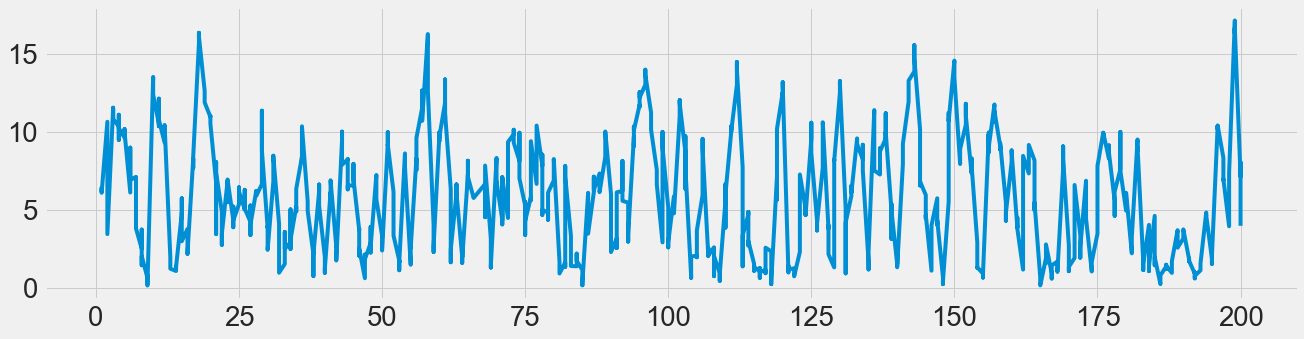

In [31]:
# Tmstamp 당 Patv 추세를 확인.
plt.figure(figsize=(20, 5))
#j = 201 # Day
j = 0 # hour
for i in range(1, 2): # TurbID / group 6
    plt.plot(df[(df['TurbID']==i) & (df['hour']==j)]['Day'], df[(df['TurbID']==i) & (df['hour']==j)]['Wspd'])
    #plt.plot(train_data[(train_data['TurbID']==i)]['Day'], train_data[(train_data['TurbID']==i)]['Patv'])
    #plt.xticks([])
# k = 21 # turb id
# plt.plot(df1[(df1['TurbID']==k) & (df1['Day']==j)]['Tmstamp'], df1[(df1['TurbID']==k) & (df1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

In [32]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


# 정렬한 것 원래대로 만들기.

In [33]:
train_data = train_data.sort_values(by=['TurbID', 'Day', 'hour', 'minute'])
train_data.reset_index(drop=True, inplace=True)
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [34]:
train_data[143:160]

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
143,1,1,143,23,5,9.95,-0.42,28.31,42.09,-8.17,1.01,1.01,1.01,-0.20,1361.95
144,1,2,0,0,0,10.64,-1.59,28.10,42.17,-9.66,1.01,1.01,1.01,-0.27,1468.21
145,1,2,1,0,1,7.00,0.84,27.87,42.05,-2.77,1.00,1.00,1.00,-0.16,718.12
146,1,2,2,0,2,5.87,-2.61,27.38,41.73,-9.17,0.99,0.99,0.99,-0.27,442.15
147,1,2,3,0,3,4.00,3.26,27.13,41.76,-8.20,0.99,0.99,0.99,-0.21,196.04
148,1,2,4,0,4,4.03,2.88,26.99,41.66,2.82,0.99,0.99,0.99,-0.23,234.35
149,1,2,5,0,5,3.46,1.32,26.80,41.36,38.08,0.99,0.99,0.99,-0.23,124.94
150,1,2,6,1,0,3.96,-0.03,26.52,40.87,22.25,0.99,0.99,0.99,-0.24,179.06
151,1,2,7,1,1,4.63,-2.50,26.25,39.97,38.62,0.99,0.99,0.99,-0.24,253.25
152,1,2,8,1,2,5.40,-0.77,26.01,39.09,46.95,0.99,0.99,0.99,-0.25,347.00


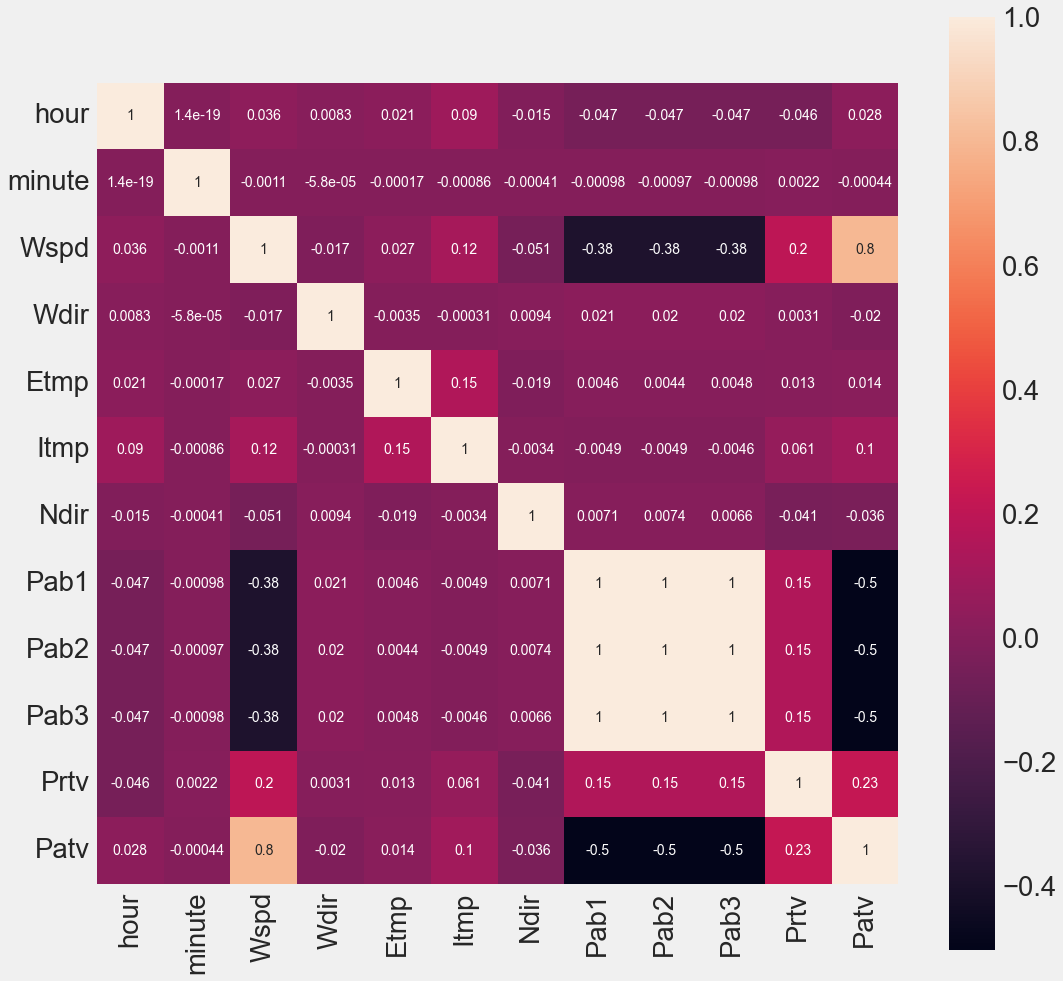

In [35]:
plt.subplots(figsize=(16, 16))
sns.heatmap(train_data[['hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']].corr(), annot=True, square=True)
plt.show()

In [36]:
train_data.columns

Index(['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp',
       'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv'],
      dtype='object')

In [37]:
train_data.isnull().sum()

TurbID     0
Day        0
Tmstamp    0
hour       0
minute     0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64

In [38]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [39]:
#     a = train_data[(train_data['TurbID']==i)].copy()
#     a.reset_index(drop=True, inplace=True)

In [40]:
# k = train_data[(train_data['minute'] == 0)]
# k.reset_index(drop=True, inplace=True)

In [41]:
# k

In [42]:
# train_data = train_data.fillna(method = 'ffill').fillna(method='bfill')
# train_data.isnull().sum()

In [43]:
# f4 = (valid_data2['hour']==1) | (valid_data2['hour']==2)
# c = valid_data2.loc[f4].copy()

In [44]:
# c.reset_index(drop=True, inplace=True)
# c

In [45]:
# print(RMSE_MAE(c['Itmp'], c['comparison']))

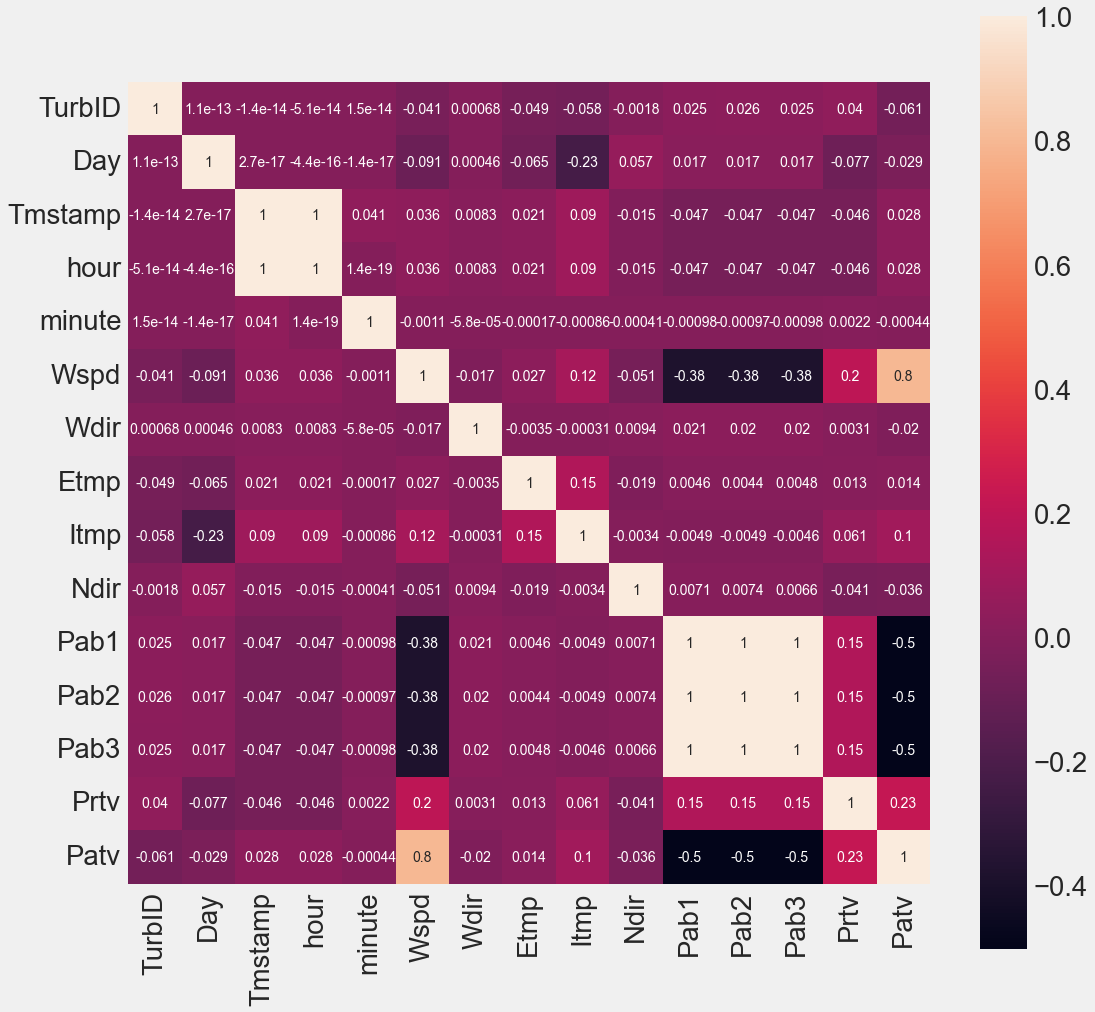

In [46]:
plt.subplots(figsize=(16, 16))
sns.heatmap(train_data.corr(), annot=True, square=True)
plt.show()

In [47]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [48]:
asdfasdf

NameError: name 'asdfasdf' is not defined

# train_set 만들기

In [49]:
from keras import backend as K
from pandas import DataFrame
from pandas import concat
from xgboost import XGBRegressor
from pandas_datareader import data as pdr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

def RMSE_MAE(y_true, y_pred):
    mse1 = K.mean(K.square((y_true - y_pred)))
    mae1 = K.mean(K.abs((y_true - y_pred)))
    
    return (K.sqrt(mse1) + mae1) / 2

In [6]:
import pandas as pd

In [14]:
j=1
k = train_data[train_data['TurbID'] == j]
k.reset_index(drop=True, inplace=True)

values = k.Wspd.values

days_in = 100
day_out = 1

df = pd.DataFrame(values)
raw = []

for i in range(days_in, 0, -1):
    raw.append(df.shift(i))
for i in range(0, day_out):
    raw.append(df.shift(-i))

sum = pd.concat(raw, axis=1)
sum.dropna(inplace=True)

train = sum.values

In [15]:
sum

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,6.17,6.27,6.42,6.25,6.10,6.77,6.70,6.44,6.25,6.87,...,0.00,4.82,2.69,6.19,4.17,4.20,4.89,4.28,5.34,2.19
102,6.27,6.42,6.25,6.10,6.77,6.70,6.44,6.25,6.87,6.60,...,4.82,2.69,6.19,4.17,4.20,4.89,4.28,5.34,2.19,4.03
103,6.42,6.25,6.10,6.77,6.70,6.44,6.25,6.87,6.60,6.71,...,2.69,6.19,4.17,4.20,4.89,4.28,5.34,2.19,4.03,4.24
104,6.25,6.10,6.77,6.70,6.44,6.25,6.87,6.60,6.71,6.86,...,6.19,4.17,4.20,4.89,4.28,5.34,2.19,4.03,4.24,3.18
105,6.10,6.77,6.70,6.44,6.25,6.87,6.60,6.71,6.86,6.88,...,4.17,4.20,4.89,4.28,5.34,2.19,4.03,4.24,3.18,4.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,2.76,3.59,3.89,3.23,2.45,1.93,1.88,2.64,2.37,2.12,...,4.23,5.29,4.82,5.10,5.80,6.07,6.27,6.38,5.44,4.70
28796,3.59,3.89,3.23,2.45,1.93,1.88,2.64,2.37,2.12,2.49,...,5.29,4.82,5.10,5.80,6.07,6.27,6.38,5.44,4.70,3.53
28797,3.89,3.23,2.45,1.93,1.88,2.64,2.37,2.12,2.49,2.07,...,4.82,5.10,5.80,6.07,6.27,6.38,5.44,4.70,3.53,3.50
28798,3.23,2.45,1.93,1.88,2.64,2.37,2.12,2.49,2.07,1.72,...,5.10,5.80,6.07,6.27,6.38,5.44,4.70,3.53,3.50,4.26


In [75]:
turbin_pred = []
for j in range(2, 3):
    print(j,"번째 Turbin 반복")
    k = train_data[train_data['TurbID'] == j]
    k.reset_index(drop=True, inplace=True)
    
    values = k.Wspd.values

    days_in = 100
    day_out = 1
    
    df = pd.DataFrame(values)
    raw = []

    for i in range(days_in, 0, -1):
        raw.append(df.shift(i))
    for i in range(0, day_out):
        raw.append(df.shift(-i))

    sum = concat(raw, axis=1)
    sum.dropna(inplace=True)

    train = sum.values
    
    
#     # 여기에 정규화 넣어주기. (Standard Scaler)
#     scaler = StandardScaler()
#     scaler.fit(train)
#     train = scaler.transform(train)
    
    # 데이터 나누기.
    X_train, Y_train = train[:, :-1], train[:, -1]
    
    
    #예측 해야할 개수만큼 반복
    myIter = 288
    for i in range(myIter):
        print(i+1,"반복")
        # 만약 여기에다가 Scaler를 넣어주면?
        
        
#         print("X_train: ", X_train)
#         print("Y_train: ", Y_train)
        #xgb_reg = XGBRegressor(n_estimators = 50)
        lr_model = LinearRegression()
        
        #xgb_reg.fit(X_train, Y_train, eval_set=[(X_train, Y_train)], early_stopping_rounds=300,
                #verbose=False)
        lr_model.fit(X_train, Y_train)
    
    
        #n+1일 값 찾기
        # 28789~28799 마지막 10개가 last_X 그 다음에 예측한 것이 last_Y
        last_X=np.concatenate((X_train[-1][1:],np.array([Y_train[-1]])),axis=0) # X_train[-1]의 맨 처음을 뺀 나머지 [1:] (9개)와 Y_train[-1]을 합쳐서 label_X를 만듦.
        last_Y = lr_model.predict(np.array([last_X])) # 새롭게 만든 last_X를 예측.해서 last_Y에 저장.
        
        #n+1일 값 추가
        # last_X까지 new_X_train에 추가하고
        # 예측해서 나온 lasy_Y를 Y_train에 추가.
        new_X_train=np.concatenate((X_train[:],np.array([last_X])),axis=0)
        new_Y_train=np.concatenate((Y_train[:],last_Y),axis=0)
        
        X_train=np.array(new_X_train)
        Y_train=np.array(new_Y_train)
    
    
    pred = Y_train[-288:]
#     pred = scaler.inverse_transform(pred)
    turbin_pred.append(pred)

2 번째 Turbin 반복
1 반복
2 반복
3 반복
4 반복
5 반복
6 반복
7 반복
8 반복
9 반복
10 반복
11 반복
12 반복
13 반복
14 반복
15 반복
16 반복
17 반복
18 반복
19 반복
20 반복
21 반복
22 반복
23 반복
24 반복
25 반복
26 반복
27 반복
28 반복
29 반복
30 반복
31 반복
32 반복
33 반복
34 반복
35 반복
36 반복
37 반복
38 반복
39 반복
40 반복
41 반복
42 반복
43 반복
44 반복
45 반복
46 반복
47 반복
48 반복
49 반복
50 반복
51 반복
52 반복
53 반복
54 반복
55 반복
56 반복
57 반복
58 반복
59 반복
60 반복
61 반복
62 반복
63 반복
64 반복
65 반복
66 반복
67 반복
68 반복
69 반복
70 반복
71 반복
72 반복
73 반복
74 반복
75 반복
76 반복
77 반복
78 반복
79 반복
80 반복
81 반복
82 반복
83 반복
84 반복
85 반복
86 반복
87 반복
88 반복
89 반복
90 반복
91 반복
92 반복
93 반복
94 반복
95 반복
96 반복
97 반복
98 반복
99 반복
100 반복
101 반복
102 반복
103 반복
104 반복
105 반복
106 반복
107 반복
108 반복
109 반복
110 반복
111 반복
112 반복
113 반복
114 반복
115 반복
116 반복
117 반복
118 반복
119 반복
120 반복
121 반복
122 반복
123 반복
124 반복
125 반복
126 반복
127 반복
128 반복
129 반복
130 반복
131 반복
132 반복
133 반복
134 반복
135 반복
136 반복
137 반복
138 반복
139 반복
140 반복
141 반복
142 반복
143 반복
144 반복
145 반복
146 반복
147 반복
148 반복
149 반복
150 반복
151 반복
152 반복
153 반복
154 반복
155 반복
156 반복
1

In [76]:
pred_list = []
for i in range(134):
    pred_list += list(pred)
len(pred_list)

38592

In [77]:
# pred_list = []
# for i in range(134):
#     pred_list += list(turbin_pred[i])
# pred_list

# 201일, 202일 Wspd

In [78]:
label_data = pd.read_csv('data/wtbdata_245days.csv')
label_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727515,134,245,23:10,7.79,2.80,-0.07,3.95,216.51,6.03,6.03,6.03,-111.69,601.44
4727516,134,245,23:20,8.06,4.39,0.23,3.94,216.51,5.81,5.81,5.81,-72.67,673.79
4727517,134,245,23:30,8.08,2.28,-0.16,4.15,216.51,0.68,0.68,0.68,-118.70,999.36
4727518,134,245,23:40,8.46,0.80,-0.14,4.32,216.51,0.02,0.02,0.02,-58.12,1100.89


In [79]:
f1 = (label_data['Day']==201) | (label_data['Day']==202)
valid_data = label_data.loc[f1]
valid_data.reset_index(drop=True, inplace=True)
valid_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,201,00:00,4.57,0.02,11.56,29.01,196.10,0.99,0.99,0.99,-0.28,284.93
1,1,201,00:10,5.04,2.73,9.71,27.95,196.15,0.99,0.99,0.99,-0.29,353.49
2,1,201,00:20,5.12,2.85,10.63,27.97,196.15,0.99,0.99,0.99,-0.30,351.27
3,1,201,00:30,4.95,4.76,10.32,28.08,196.15,0.99,0.99,0.99,-0.27,303.77
4,1,201,00:40,5.07,4.01,9.65,27.32,196.89,0.99,0.99,0.99,-0.31,318.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,134,202,23:10,9.91,3.38,11.03,11.58,342.92,4.34,4.34,4.34,124.65,1205.58
38588,134,202,23:20,10.02,3.00,11.00,11.58,342.92,4.89,4.89,4.89,145.37,1186.92
38589,134,202,23:30,10.10,3.66,11.02,11.60,342.92,4.57,4.57,4.57,125.36,1252.53
38590,134,202,23:40,9.82,5.10,10.80,11.56,342.92,4.28,4.28,4.28,113.83,1220.91


In [80]:
def make_hour(values):
    a, b = values.split(':')
    
    return int(a)

valid_data['hour'] = valid_data['Tmstamp'].apply(lambda x: make_hour(x))   

In [81]:
def make_minute(values):
    a, b = values.split(':')
    if b == '00':
        return 0
    elif b== '10':
        return 1
    elif b== '20':
        return 2
    elif b== '30':
        return 3
    elif b== '40':
        return 4
    elif b== '50':
        return 5

valid_data['minute'] = valid_data['Tmstamp'].apply(lambda x: make_minute(x))

In [82]:
# 순서 넘겨주기.
valid_data = valid_data[['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]

In [83]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(valid_data["Tmstamp"]))

valid_data["Tmstamp"] = valid_data["Tmstamp"].apply(lambda x : tms_list.index(x))

In [84]:
valid_data3 = valid_data.copy()

In [85]:
valid_data['comparison'] = pred_list

In [86]:
a = valid_data[valid_data['Patv'].isnull()==True].index
valid_data.drop(a, axis='index', inplace=True)

In [87]:
a =  valid_data[(valid_data['Patv'] <=0) & (valid_data['Wspd'] > 2.5)].index 
valid_data.drop(a, axis='index', inplace=True)

In [88]:
a = valid_data[(valid_data['Pab1'] > 89) | (valid_data['Pab2'] > 89) | (valid_data['Pab3'] > 89)].index
valid_data.drop(a, axis='index', inplace=True)

In [89]:
a = valid_data[(valid_data['Ndir'] > 720) | (valid_data['Ndir'] < -720)].index
valid_data.drop(a, axis='index', inplace=True)

In [90]:
a = valid_data[(valid_data['Wdir'] > 180) | (valid_data['Wdir'] < -180)].index
valid_data.drop(a, axis='index', inplace=True)

In [91]:
valid_data = valid_data.reset_index()
valid_data.drop(columns=['index'], inplace=True)

In [92]:
valid_data.shape

(29777, 16)

# 전체 점수:

In [93]:
print(RMSE_MAE(valid_data['Wspd'], valid_data['comparison']))

tf.Tensor(2.186483631079601, shape=(), dtype=float64)


In [ ]:
sadfasdfas

In [94]:
sample_submission

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,201,00:00,4.075980,0,0,0,0,0,0,0,0,9999
1,1,1,201,00:10,4.114086,0,0,0,0,0,0,0,0,9999
2,2,1,201,00:20,4.147869,0,0,0,0,0,0,0,0,9999
3,3,1,201,00:30,4.100816,0,0,0,0,0,0,0,0,9999
4,4,1,201,00:40,4.099694,0,0,0,0,0,0,0,0,9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,38587,134,202,23:10,5.421215,0,0,0,0,0,0,0,0,9999
38588,38588,134,202,23:20,5.422422,0,0,0,0,0,0,0,0,9999
38589,38589,134,202,23:30,5.423607,0,0,0,0,0,0,0,0,9999
38590,38590,134,202,23:40,5.424781,0,0,0,0,0,0,0,0,9999


In [97]:
sample_submission['Wspd'] = pred_list
sample_submission['Wspd'].isnull().sum()

0

In [98]:
sample_submission.to_csv('submission/0717_LSTM_Wspd_cv_test_2_19.csv')

# 부분 점수:

In [72]:
valid_data3 = valid_data3.fillna(method='ffill')
valid_data3.isnull().sum()

TurbID     0
Day        0
Tmstamp    0
hour       0
minute     0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64

In [73]:
y_true = valid_data3['Wspd']

In [74]:

k = 99999999
m = 0
for i in range(0, 134):
    
    turbin_pred[i] = turbin_pred[i].reshape(-1)
    
    b = []
    for _ in range(134):
        b += list(turbin_pred[i]) # 1번 터빈만 합친거.
        
    m = RMSE_MAE(y_true, b)
    
    if m < k:
        k = m
        n = i
        print(k)
    

tf.Tensor(2.491985533254944, shape=(), dtype=float64)


IndexError: list index out of range

In [ ]:
print(f'{n}번째 Turbin의 점수: {k}')

In [ ]:
len(pred_list)

# 이거는 그룹별로 모아서 ex) Group 6으로 나눈다면 각 Group에서 대표하는 터빈 6개만 뽑아서 나머지로 채워주기.
=> 이게 만약 좋게 나온다면. 각 터빈별로 대표를 뽑아서하는 것도 의미있어보임.

In [ ]:
RMSE_MAE(y_true, pred_list)

In [ ]:
asdadsa

In [ ]:
# 우선, Turbin 1번만.

k

In [ ]:
# size = len(k)
# sequence = 10 # 앞에 10개를 확인. (앞의 Tmstamp 10개)
# # dropout=0.3
# # epoch=30
# # batch_size=128
# verbose=1

# dt_index = list(range(288))
# myIter = len(dt_index)

In [ ]:
# myIter

In [ ]:
# X_train, Y_train = [], []

# for i in range(size-sequence):
#     X_train.append(np.array(k.iloc[i:i+sequence, 5:6])) # Wspd만
#     Y_train.append(np.array(k.iloc[i+sequence, 5:6])) # Wspd만.

# X_train=np.array(X_train)
# Y_train=np.array(Y_train)
# print(len(X_train),len(Y_train)) 
# # 마지막으로보면 X_train의 마지막 Wspd는 4.26, 마지막 Y_train의 Wspd는 3.97

In [ ]:
# X_train.reshape(-1, 1, 10)

In [ ]:
# train

In [ ]:
# X_train, Y_train = train[:, :-1], train[:, -1]
# print(X_train.shape, Y_train.shape)

In [ ]:
#예측 해야할 개수만큼 반복
myIter = 288
for i in range(myIter):
    print(i+1,"반복")
    xgb_reg = XGBRegressor(n_estimators = 50)
    
    xgb_reg.fit(X_train, Y_train, eval_set=[(X_train, Y_train)], early_stopping_rounds=300,
            verbose=False)
    
    #n+1일 값 찾기
    # 28789~28799 마지막 10개가 last_X 그 다음에 예측한 것이 last_Y
    last_X=np.concatenate((X_train[-1][1:],np.array([Y_train[-1]])),axis=0) # X_train[-1]의 맨 처음을 뺀 나머지 [1:] (9개)와 Y_train[-1]을 합쳐서 label_X를 만듦.
    last_Y = xgb_reg.predict(np.array([last_X])) # 새롭게 만든 last_X를 예측.해서 last_Y에 저장.
    
    #n+1일 값 추가
    # last_X까지 new_X_train에 추가하고
    # 예측해서 나온 lasy_Y를 Y_train에 추가.
    new_X_train=np.concatenate((X_train[:],np.array([last_X])),axis=0)
    new_Y_train=np.concatenate((Y_train[:],last_Y),axis=0)
    
    X_train=np.array(new_X_train)
    Y_train=np.array(new_Y_train)

In [ ]:
# 출력확인
print(len(X_train),len(Y_train))

In [ ]:
Y_train

In [ ]:
pred = Y_train[-288:]

# 201일, 202일 Wspd

In [1]:
label_data = pd.read_csv('data/wtbdata_245days.csv')
label_data

NameError: name 'pd' is not defined

In [ ]:
f1 = (label_data['Day']==201) | (label_data['Day']==202)
valid_data = label_data.loc[f1]
valid_data.reset_index(drop=True, inplace=True)
valid_data

In [2]:
def make_hour(values):
    a, b = values.split(':')
    
    return int(a)

valid_data['hour'] = valid_data['Tmstamp'].apply(lambda x: make_hour(x))   

NameError: name 'valid_data' is not defined

In [3]:
def make_minute(values):
    a, b = values.split(':')
    if b == '00':
        return 0
    elif b== '10':
        return 1
    elif b== '20':
        return 2
    elif b== '30':
        return 3
    elif b== '40':
        return 4
    elif b== '50':
        return 5

valid_data['minute'] = valid_data['Tmstamp'].apply(lambda x: make_minute(x))

NameError: name 'valid_data' is not defined

In [ ]:
# 순서 넘겨주기.
valid_data = valid_data[['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]

In [ ]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(valid_data["Tmstamp"]))

valid_data["Tmstamp"] = valid_data["Tmstamp"].apply(lambda x : tms_list.index(x))

In [ ]:
valid_data3 = valid_data.copy()

# 한가지 풍속

In [ ]:
valid_data3 = valid_data3.fillna(method='ffill')

In [ ]:
valid_data3.isnull().sum()

In [ ]:
y_true = valid_data3['Wspd'].values

In [ ]:
b = []
for l in range(134):
    b += list(pred)

b = np.array(b)
RMSE_MAE(y_true, b)

In [ ]:
type(b)

In [ ]:
type(y_true)

In [ ]:
asfdasdfasd